In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import measure, color, io

In [2]:
base_name = 'gen_two'
score_file_name = f'../data/{base_name}.png'
mask_file_name = f'../data/{base_name}_mask.png'
rotation_deg = 0 #-1.3

In [3]:
# alpha_composite score image.  Have to do this in RGB, then final-convert to grey.
score_image = Image.open(score_file_name)
score_image = score_image.rotate(rotation_deg)
background = Image.new('RGBA', score_image.size, (255,255,255))
score_image = Image.alpha_composite(background,score_image)
score_image = score_image.convert('L')

In [4]:
# deal with image via PIL...
if True:
    mask_image = Image.open(mask_file_name).convert('L')
    # let's rotate it a bit...
    mask_image = mask_image.rotate(rotation_deg)
    mask_array = np.reshape(np.asarray(mask_image),(mask_image.height,mask_image.width))
else:
    # Or try skimage (will convert to 0-1.0 float)
    mask_array = color.rgb2gray(io.imread(mask_file_name)) * 255

print(mask_array.shape,np.min(mask_array),np.max(mask_array))

(1123, 794) 0 105


In [5]:
# label individual regions
mask_labels, num_labels = measure.label(mask_array,return_num=True,background=0.0,connectivity=2)
print(mask_labels.shape,num_labels)

(1123, 794) 12


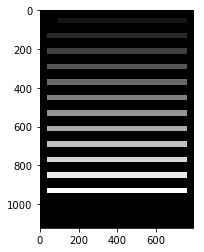

In [6]:
plt.imshow(mask_labels,cmap="gray")
plt.show()

In [7]:
# find extents and lines of best fit.
regions = []
for i in range(num_labels):
    cur_ranges = np.where(mask_labels==i+1)
    y0,x0 = cur_ranges[0][0],cur_ranges[1][0]
    y1,x1 = cur_ranges[0][-1],cur_ranges[1][-1]
    m1,b1 = np.polyfit(cur_ranges[1],cur_ranges[0],1)
    print(i,x0,y0,x1,y1,m1,b1,(y1+y0)/2)
    regions.append((x0,y0,x1,y1,m1,b1))

0 94 39 755 65 1.6074296867e-16 52.0 52.0
1 38 118 755 145 -2.29391178027e-16 131.5 131.5
2 38 198 755 225 -2.5806507528e-16 211.5 211.5
3 38 278 755 304 -5.84001353923e-16 291.0 291.0
4 38 358 755 384 -4.67201083139e-16 371.0 371.0
5 38 437 755 464 -1.14695589013e-16 450.5 450.5
6 38 517 755 544 -6.8817353408e-16 530.5 530.5
7 38 597 755 623 0.0 610.0 610.0
8 38 677 755 703 -1.16800270785e-15 690.0 690.0
9 38 756 755 783 -1.60573824619e-15 769.5 769.5
10 38 836 755 863 -9.17564712106e-16 849.5 849.5
11 38 916 755 942 1.05120243706e-15 929.0 929.0


In [8]:
#   -----XXXXXX------XXXXXX------XXXXXX------
#              \--------^-------/
#              region to pass to NN
image_regions = []
for i in range(len(regions)):
    h = regions[i][3] - regions[i][1]
    if i < len(regions)-1:
        dy = regions[i+1][1] - regions[i][3]
    else:
        dy = regions[i][1] - regions[i-1][3]
    # create starting rectangle to send and center it
    y0 = regions[i][1] - dy # can go < 0 or > height
    y1 = regions[i][3] + dy 
    dy2 = y1 - y0
    x0 = regions[i][0] - dy2/2
    x1 = x0 + dy2
    print(i,x0,y0,x1,y1,dy2)
    image_regions.append((x0,y0,x1,y1))

0 28.0 -14 160.0 118 132
1 -28.5 65 104.5 198 133
2 -28.5 145 104.5 278 133
3 -29.0 224 105.0 358 134
4 -28.0 305 104.0 437 132
5 -28.5 384 104.5 517 133
6 -28.5 464 104.5 597 133
7 -29.0 543 105.0 677 134
8 -28.0 624 104.0 756 132
9 -28.5 703 104.5 836 133
10 -28.5 783 104.5 916 133
11 -28.0 863 104.0 995 132


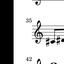

In [9]:
nn_input_size = (64,64) # at this size, your really need ANTIALIAS.  
ii = 5
score_image.crop(image_regions[ii]).resize(nn_input_size,Image.ANTIALIAS)

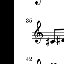

In [10]:
# compare without
score_image.crop(image_regions[ii]).resize(nn_input_size)